In [1]:
import numpy as np
from utilities import *
from imbalance_gain import *
import matplotlib.pyplot as plt
import pickle

In [2]:
trajectory = pickle.load(open("data/test_trajectory.p", "rb"))
traj_length = trajectory.shape[0]
print(trajectory.shape)

(105001, 7)


# 1) Using all coordinates of X and Y

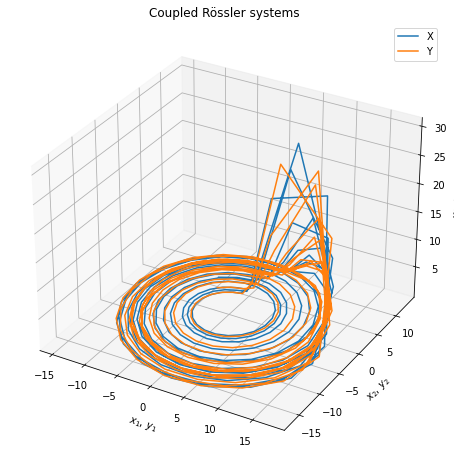

In [5]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

start_plot = 5000
end_plot = 5300

x_1 = trajectory[start_plot:end_plot,1]
x_2 = trajectory[start_plot:end_plot,2]
x_3 = trajectory[start_plot:end_plot,3]
y_1 = trajectory[start_plot:end_plot,4]
y_2 = trajectory[start_plot:end_plot,5]
y_3 = trajectory[start_plot:end_plot,6]

ax.plot3D(x_1, x_2, x_3, label="X")
ax.plot3D(y_1, y_2, y_3, label="Y")

ax.set_title("Coupled Rössler systems")
ax.set_xlabel("$x_1,\,y_1$")
ax.set_ylabel("$x_2,\,y_2$")
ax.set_zlabel("$x_3,\,y_3$")

ax.legend()
plt.show()

## Information Imbalance vs $\alpha$

In [6]:
tau = 20
N = 2500
sample_times = np.linspace(5000,traj_length-tau-1,N,dtype=int)
alphas = np.linspace(0,1,100)
k = 5
n_jobs = 4

In [7]:
X0 = trajectory[sample_times,1:4]
Y0 = trajectory[sample_times,4:]
rank_matrix_Xtau = compute_rank_matrix(trajectory[sample_times + tau,1:4])
rank_matrix_Ytau = compute_rank_matrix(trajectory[sample_times + tau,4:])

info_imbalances_X_to_Y = scan_alphas(cause_present=X0, effect_present=Y0, rank_matrix_effect_future=rank_matrix_Ytau, 
                                     alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")
info_imbalances_Y_to_X = scan_alphas(cause_present=Y0, effect_present=X0, rank_matrix_effect_future=rank_matrix_Xtau, 
                                     alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")

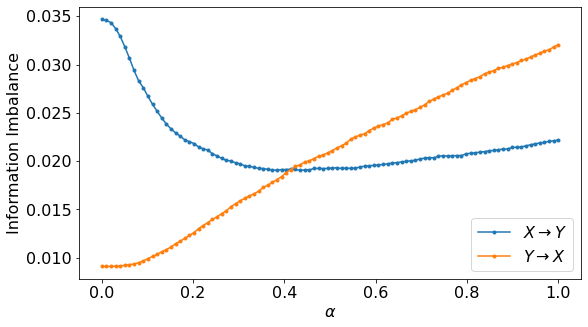

In [8]:
plt.rcParams['font.size'] = 16

plt.figure(figsize=(9,5))
plt.plot(alphas, info_imbalances_X_to_Y, 'o-', markersize=3, label="$X\\rightarrow Y$")
plt.plot(alphas, info_imbalances_Y_to_X, 'o-', markersize=3, label="$Y\\rightarrow X$")
plt.xlabel("$\\alpha$")
plt.ylabel("Information Imbalance")
plt.legend()
plt.show()

## Imbalance Gains

In [9]:
imbalance_gain_X_to_Y, index_optimal_alpha_X_to_Y = compute_imbalance_gain(info_imbalances_X_to_Y)
imbalance_gain_Y_to_X, index_optimal_alpha_Y_to_X = compute_imbalance_gain(info_imbalances_Y_to_X)

print("Imbalance Gain X -> Y: {:.2f} %".format(100*imbalance_gain_X_to_Y))
print("Imbalance Gain Y -> X: {:.2f} %".format(100*imbalance_gain_Y_to_X))

print("Optimal alpha X -> Y: {:.2f}".format(alphas[index_optimal_alpha_X_to_Y]))
print("Optimal alpha Y -> X: {:.2f}".format(alphas[index_optimal_alpha_Y_to_X]))

Imbalance Gain X -> Y: 45.10 %
Imbalance Gain Y -> X: 0.08 %
Optimal alpha X -> Y: 0.43
Optimal alpha Y -> X: 0.01


# 2) Using time-delay embeddings

In [10]:
E = 3
tau_e = 1
traj_length = trajectory.shape[0] - tau_e*E

In [11]:
X_time_delay, Y_time_delay = construct_time_delay_embedding(X=trajectory[:,1], Y=trajectory[:,4], 
                                                            E=E, tau_e=tau_e, sample_times=None)

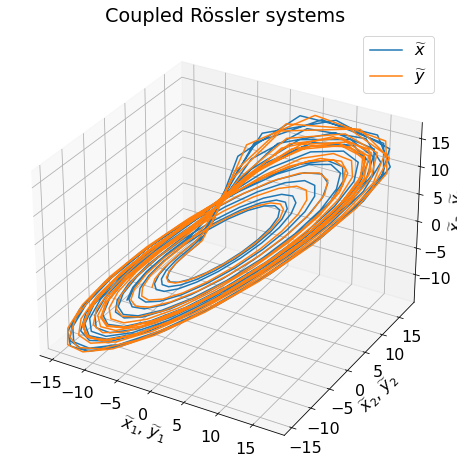

In [12]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

start_plot = 5000
end_plot = 5300

x_1 = X_time_delay[start_plot:end_plot,0]
x_2 = X_time_delay[start_plot:end_plot,1]
x_3 = X_time_delay[start_plot:end_plot,2]
y_1 = Y_time_delay[start_plot:end_plot,0]
y_2 = Y_time_delay[start_plot:end_plot,1]
y_3 = Y_time_delay[start_plot:end_plot,2]

ax.plot3D(x_1, x_2, x_3, label="$\\widetilde{x}$")
ax.plot3D(y_1, y_2, y_3, label="$\\widetilde{y}$")

ax.set_title("Coupled Rössler systems")
ax.set_xlabel("$\\widetilde{x}_1,\,\\widetilde{y}_1$")
ax.set_ylabel("$\\widetilde{x}_2,\,\\widetilde{y}_2$")
ax.set_zlabel("$\\widetilde{x}_3,\,\\widetilde{y}_3$")

ax.legend()
plt.show()

## Information Imbalance vs $\alpha$

In [13]:
tau = 20
N = 2500
sample_times = np.linspace(5000,traj_length-tau-1,N,dtype=int)
alphas = np.linspace(0,1,100)
k = 5
n_jobs = 4

In [14]:
X0 = X_time_delay[sample_times]
Y0 = Y_time_delay[sample_times]
rank_matrix_Xtau = compute_rank_matrix(X_time_delay[sample_times + tau])
rank_matrix_Ytau = compute_rank_matrix(Y_time_delay[sample_times + tau])

# alternative, more efficient for memory storage:
#X0, Y0 = construct_time_delay_embedding(X=trajectory[:,1], Y=trajectory[:,4],
#                                        E=E, tau_e=tau_e, sample_times=sample_times)
#Xtau, Ytau = construct_time_delay_embedding(X=trajectory[:,1], Y=trajectory[:,4],
#                                        E=E, tau_e=tau_e, sample_times=sample_times+tau)
#rank_matrix_Xtau = compute_rank_matrix(Xtau)
#rank_matrix_Ytau = compute_rank_matrix(Ytau)

info_imbalances_X_to_Y = scan_alphas(cause_present=X0, effect_present=Y0, rank_matrix_effect_future=rank_matrix_Ytau, 
                                     alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")
info_imbalances_Y_to_X = scan_alphas(cause_present=Y0, effect_present=X0, rank_matrix_effect_future=rank_matrix_Xtau, 
                                     alphas=alphas, k=k, n_jobs=n_jobs, metric="euclidean")

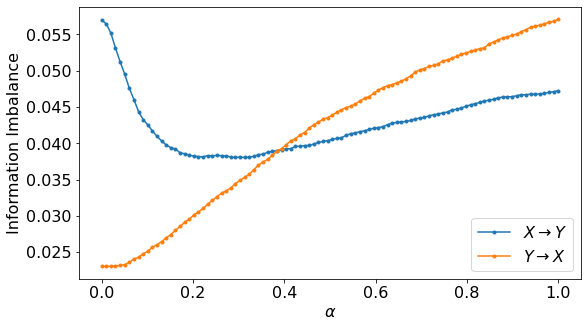

In [15]:
plt.rcParams['font.size'] = 16

plt.figure(figsize=(9,5))
plt.plot(alphas, info_imbalances_X_to_Y, 'o-', markersize=3, label="$X\\rightarrow Y$")
plt.plot(alphas, info_imbalances_Y_to_X, 'o-', markersize=3, label="$Y\\rightarrow X$")
plt.xlabel("$\\alpha$")
plt.ylabel("Information Imbalance")
plt.legend()
plt.show()

## Imbalance Gains

In [17]:
imbalance_gain_X_to_Y, index_optimal_alpha_X_to_Y = compute_imbalance_gain(info_imbalances_X_to_Y)
imbalance_gain_Y_to_X, index_optimal_alpha_Y_to_X = compute_imbalance_gain(info_imbalances_Y_to_X)

print("Imbalance Gain X -> Y: {:.2f} %".format(100*imbalance_gain_X_to_Y))
print("Imbalance Gain Y -> X: {:.2f} %".format(100*imbalance_gain_Y_to_X))

print("Optimal alpha X -> Y: {:.2f}".format(alphas[index_optimal_alpha_X_to_Y]))
print("Optimal alpha Y -> X: {:.2f}".format(alphas[index_optimal_alpha_Y_to_X]))

Imbalance Gain X -> Y: 33.22 %
Imbalance Gain Y -> X: 0.00 %
Optimal alpha X -> Y: 0.31
Optimal alpha Y -> X: 0.00
